# Model 18: The evolution of social learning

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model18.html

## Introduction

- 遺伝子と文化の共進化 (Gene-culture coevolution) 
    - ここまでで、学習バイアスや人口統計学的プロセスによって、文化的特徴の人口頻度の変化によって、文化進化のメカニズムを研究してきた。
    - しかし、そもそもこの学習バイアス自体はどのように進化したのだろうか？
    - これは、遺伝子-文化共進化 (gene-culture coevolution) モデルであり、社会的学習バイアスを表す遺伝子の様なものがあり、その遺伝子が保有者に獲得させる文化的特質の適応的価値の結果として出現拡散すると仮定している。
- 最も基本的な問いは、なぜ/いかにして、個人的学習から社会的学習が進化したのか？である。
    - 個人的学習と比較して、社会的学習のコストとベネフィットは何か？
    - 一般的な答えとしては、個人的学習よりも社会的学習のほうが、コスト面で有利だということである。自分で環境から学習するよりも、他人の真似をした方が楽というのは理にかなっている。
- ロジャースのパラドックス
    - ロジャースのモデル (1988) は、社会的学習が個人的学習よりもコストが低い場合には確かに進化し、社会的学習者と個人的学習者が共存することを示した。
    - しかしこのモデルは同時に、社会的学習と個人的学習が共存している集団と、個人的学習しか存在しない集団の、集団全体での平均適応度が等しいことも示した。
    - これは、社会的学習 (すなわち文化) が、個体・集団・種にとって適応的であるという一般的な主張と矛盾している。これを「ロジャースのパラドックス」という。
    - Model 18a ではこのパラドックスを再現し、Model 18b では、その解決策を提示する。

## Model 18a: Rogers’ model

In [18]:
using JupyterFormatter
enable_autoformat()

using DataFrames
using LaTeXStrings
using Plots
using StatsBase
using Test: @test, @testset

println("Julia version: ", VERSION)

Julia version: 1.9.0


In [2]:
function make_agent_df(N::Int)::DataFrame
    DataFrame(learning = fill("IL", N), behaviour = fill(false, N), fitness = fill(0.0, N))
end

function make_output_df(time_steps::Int)::DataFrame
    DataFrame(
        SLfreq = fill(0.0, time_steps),
        ILfreq = fill(0.0, time_steps),
        CLfreq = fill(0.0, time_steps),
        SLfitness = fill(0.0, time_steps),
        ILfitness = fill(0.0, time_steps),
        CLfitness = fill(0.0, time_steps),
        predictedILfitness = fill(0.0, time_steps),
    )
end

function individual_learning!(agent_df::DataFrame, pᵢ::Float64)::Nothing
    weights = Weights([pᵢ, 1 - pᵢ])
    il_vec = agent_df.learning .== "IL"
    agent_df[il_vec, :behaviour] .= sample([true, false], weights, sum(il_vec))
    return
end

function social_learning!(agent_df::DataFrame, v::Float64)::Nothing
    sl_vec = agent_df.learning .!= "IL"  # CLが入ってくる可能性があることに注意

    # if environment has changed, all social learners have incorrect beh
    if v < rand()
        agent_df[sl_vec, :behaviour] .= false
    else
        # otherwise for each social learner, pick a random demonstrator from previous timestep
        # if demonstrator is correct, adopt correct beh
        dem = rand(agent_df.behaviour, nrow(agent_df))
        agent_df[sl_vec.&&dem, :behaviour] .= true  # correct
        agent_df[sl_vec.&&.!dem, :behaviour] .= false  # incorrect
    end

    return
end

function update_fitnesses!(agent_df::DataFrame, b::Float64, cᵢ::Float64)::Nothing
    # 間違った行動を取っていれば 1 の、正しい行動を取っていれば 1 + b の適応度を獲得する
    agent_df.fitness .= [behaviour ? 1.0 + b : 1.0 for behaviour in agent_df.behaviour]

    # 個人的学習のコストを適応度から差し引く
    agent_df[agent_df.learning.=="IL", :fitness] .-= cᵢ

    return
end

function record_frequency_and_fitnesses!(
    output_df::DataFrame,
    agent_df::DataFrame,
    time_step::Int,
)::Nothing
    N = nrow(agent_df)
    sl_vec = agent_df.learning .== "SL"
    il_vec = agent_df.learning .== "IL"
    cl_vec = agent_df.learning .== "CL"

    output_df[time_step, :SLfreq] = sum(sl_vec) / N
    output_df[time_step, :ILfreq] = sum(il_vec) / N
    output_df[time_step, :CLfreq] = sum(cl_vec) / N

    output_df[time_step, :SLfitness] = mean(agent_df[sl_vec, :fitness])
    output_df[time_step, :ILfitness] = mean(agent_df[il_vec, :fitness])
    output_df[time_step, :CLfitness] = mean(agent_df[cl_vec, :fitness])

    return
end

function selection_and_reproduction!(agent_df::DataFrame)::Nothing
    relative_fitness = agent_df.fitness ./ sum(agent_df.fitness)
    agent_df.learning .=
        sample(agent_df.learning, Weights(relative_fitness), nrow(agent_df))
    return
end

function mutation_IL_SL!(agent_df::DataFrame, μ::Float64)::Nothing
    mutate = rand(nrow(agent_df)) .< μ

    il_vec = agent_df.learning .== "IL"
    sl_vec = agent_df.learning .== "SL"

    agent_df[il_vec.&&mutate, :learning] .= "SL"
    agent_df[sl_vec.&&mutate, :learning] .= "IL"

    return
end

function plot_output(df::DataFrame)::Nothing
    include_CL = (df.CLfreq != fill(0.0, nrow(df)))

    p1 = plot(xlab = "generation", ylab = "proportion of each learner", legend = false)
    plot!(df.SLfreq, lc = :orange)
    include_CL && plot!(df.ILfreq, lc = :royalblue)
    include_CL && plot!(df.CLfreq, lc = :green)

    p2 = plot(ylim = (0.5, 2), xlab = "generation", ylab = "mean fitness")
    plot!(df.SLfitness, lc = :orange, label = "social learners")
    plot!(df.ILfitness, lc = :royalblue, label = "individual learners")
    include_CL && plot!(df.CLfitness, lc = :green, label = "critical learners")

    # 集団全体の適応度
    if !include_CL
        POPfitness = df.SLfreq .* df.SLfitness .+ df.ILfreq .* df.ILfitness
        plot!(POPfitness, lc = :grey, label = "population")
    end

    hline!([df.predictedILfitness[1]], ls = :dash, lc = :black, label = false)

    display(plot(p1, p2, size = (800, 450)))
end;

In [3]:
function rogers_model(;
    N::Int = 10_000,
    time_steps::Int = 1_000,
    pᵢ::Float64 = 0.5,  # chance of discovering the correct behaviour
    b::Float64 = 1.0,   # 正しい行動を取ったときのベネフィット
    cᵢ::Float64 = 0.2,  # 個人的学習のコスト
    μ::Float64 = 0.001, # 変異率
    v::Float64 = 0.9,   # probability of changing environment
)::DataFrame
    agent_df = make_agent_df(N)
    output_df = make_output_df(time_steps)

    for time_step = 1:time_steps
        individual_learning!(agent_df, pᵢ)
        social_learning!(agent_df, v)
        update_fitnesses!(agent_df, b, cᵢ)
        record_frequency_and_fitnesses!(output_df, agent_df, time_step)
        selection_and_reproduction!(agent_df)
        mutation_IL_SL!(agent_df, μ)
    end

    output_df.predictedILfitness .= 1 + b * pᵢ - cᵢ

    return output_df
end;

### Model 18a 実験1: デフォルトパラメータ

- 社会的学習者の人口頻度は80%あたりを上下している。
- 社会的学習者の平均適応度は個人的学習者と比べて、大きな幅で振動している。これは、社会的学習の場合は、環境変化が影響するためである。
- 社会的学習者と個人的学習者の、平均適応度の平均はほぼ同じ値となっている。これはRogersのパラドックスを再現している。

mean(filter(!isnan, df.SLfitness)) = 1.3374524384265545
mean(filter(!isnan, df.ILfitness)) = 1.300482978780123


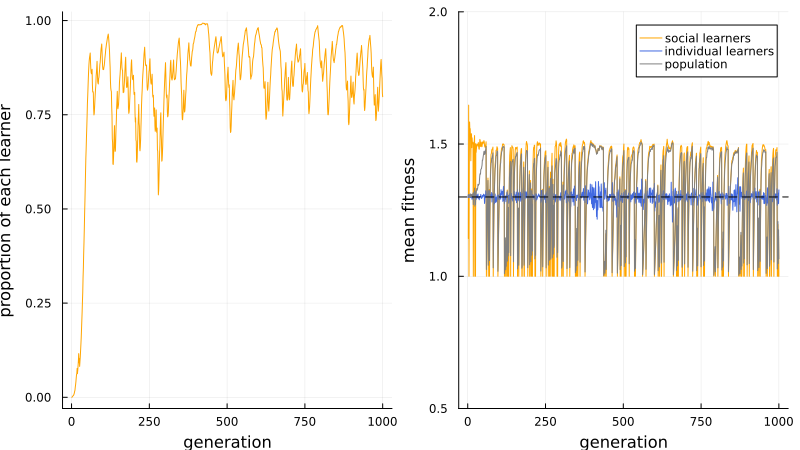

In [4]:
df = rogers_model()
@show mean(filter(!isnan, df.SLfitness))
@show mean(filter(!isnan, df.ILfitness))
plot_output(df)

### Model 18a 実験2: 環境変化がない場合 ($v = 1.0$)

- 環境変化がなければ、社会的学習者が個人的学習者を完全にリプレースする。
- これは、常に社会的学習者は個人的学習者よりも高い適応度を得ることができるためである。
- 環境変化がなければ、ロジャースのパラドックスは生じない。

mean(filter(!isnan, df.SLfitness)) = 1.502138728241716
mean(filter(!isnan, df.ILfitness)) = 1.3026706690026315


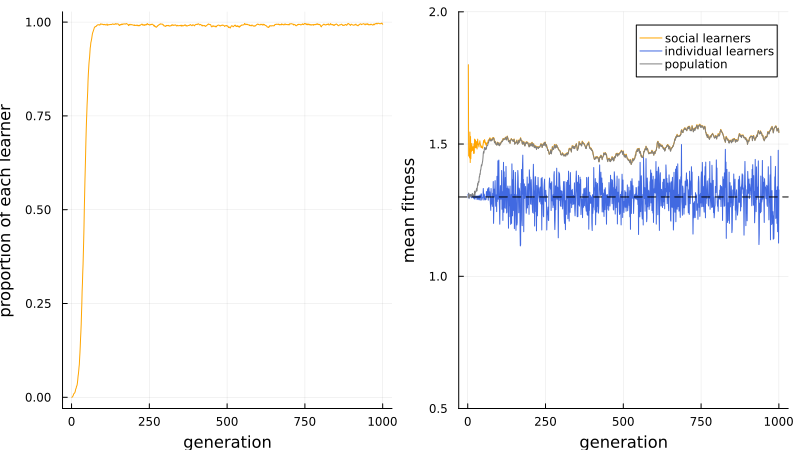

In [5]:
df = rogers_model(v = 1.0)
@show mean(filter(!isnan, df.SLfitness))
@show mean(filter(!isnan, df.ILfitness))
plot_output(df)

- 当然ながら、環境変化が大きすぎる ($v = 0.0$) と、社会的学習は全く機能しない。

mean(filter(!isnan, df.SLfitness)) = 1.0
mean(filter(!isnan, df.ILfitness)) = 1.300081979586099


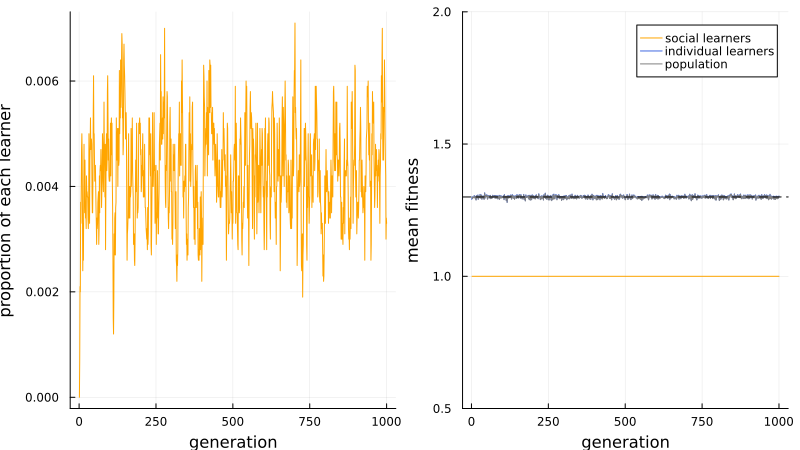

In [6]:
df = rogers_model(v = 0.0)
@show mean(filter(!isnan, df.SLfitness))
@show mean(filter(!isnan, df.ILfitness))
plot_output(df)

### Model 18a 実験3: 個人学習のコストが小さい場合 ($c_i = 0.1$)

- 個人的学習のコストが小さい場合は、社会的学習者の人口頻度は低下する。
- 平均適応度の平均に大きな差はない。つまり、ロジャースのパラドックスはこの場合も生じる。

mean(filter(!isnan, df.SLfitness)) = 1.4179338895975226
mean(filter(!isnan, df.ILfitness)) = 1.4000534291562958


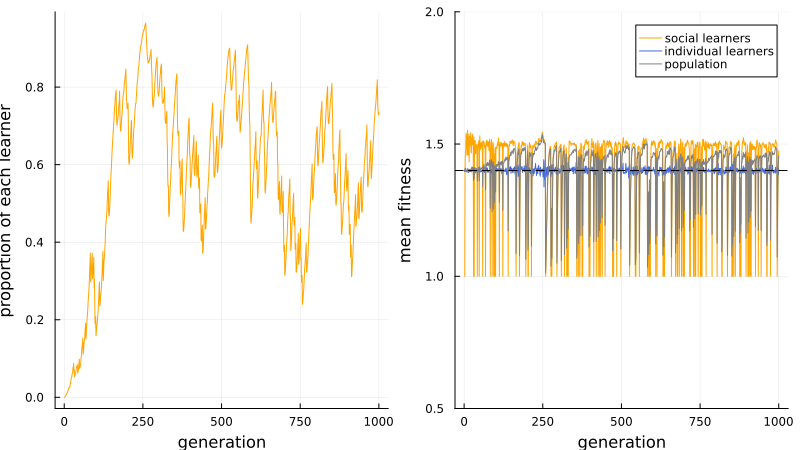

In [7]:
df = rogers_model(cᵢ = 0.1)
@show mean(filter(!isnan, df.SLfitness))
@show mean(filter(!isnan, df.ILfitness))
plot_output(df)

## Model 18b: Critical social learning

- Rogers' paradox
    - 個人的学習よりも社会的学習の方が低コストな場合、社会的学習が進化しうることを Rogers’ model は示したが、文化が適応的であるという主張に反して社会的学習は集団全体の平均適応度を増やさない。
    - 1つ目の解決策は、環境の変化をなくしてしまうことだが、それは現実に即していない。(Model18a 実験2)
    - 2つ目の解決策は、エージェントが個人的学習か社会的学習のどちらか一方しかやらないという非現実的な前提を緩和することである。
        - 社会的学習は個人的学習に取って代わるのではなくそれを補完するものなのだ。
        - 実際、社会的学習は個人的学習と同じ学習メカニズムによって立っていることが分かっている (Heyes 2012)。
    - 3つ目の解決策は、Enquist et al. (2007) の critical social learner を採用することである。
        - Critical social learners はまず社会的学習を行い、コピーしたソリューションが誤っていたら個人的学習を行う。
        - Model 18b では、Critical social learners をシミュレーションに加え、ピュア社会的学習、ピュア個人的学習と比較する。

In [8]:
function critical_learning_and_update_fitness!(
    agent_df::DataFrame,
    pᵢ::Float64,  # chance of discovering the correct behaviour
    b::Float64,   # 正しい行動を取ったときのベネフィット
    cᵢ::Float64,  # 個人的学習・クリティカル学習のコスト
)::Nothing
    cl_vec = agent_df.learning .== "CL" .&& agent_df.behaviour .== false
    weights = Weights([pᵢ, 1 - pᵢ])
    agent_df[cl_vec, :behaviour] .= sample([true, false], weights, sum(cl_vec))

    # クリティカル学習者の適応度を更新する
    agent_df[cl_vec.&&agent_df.behaviour, :fitness] .+= b
    agent_df[cl_vec, :fitness] .-= cᵢ

    return
end

function mutation_IL_SL_CL!(agent_df::DataFrame, μ::Float64)::Nothing
    mutate = rand(nrow(agent_df)) .< μ

    il_vec = (agent_df.learning .== "IL" .&& mutate)
    sl_vec = (agent_df.learning .== "SL" .&& mutate)
    cl_vec = (agent_df.learning .== "CL" .&& mutate)

    agent_df[il_vec, :learning] .= rand(["SL", "CL"], sum(il_vec))
    agent_df[sl_vec, :learning] .= rand(["CL", "IL"], sum(sl_vec))
    agent_df[cl_vec, :learning] .= rand(["IL", "SL"], sum(cl_vec))

    return
end;

In [9]:
function enquist_model(;
    N::Int = 10_000,
    time_steps::Int = 1_000,
    pᵢ::Float64 = 0.5,  # chance of discovering the correct behaviour
    b::Float64 = 1.0,   # 正しい行動を取ったときのベネフィット
    cᵢ::Float64 = 0.2,  # 個人的学習・クリティカル学習のコスト
    μ::Float64 = 0.001, # 変異率
    v::Float64 = 0.9,   # probability of changing environment
)::DataFrame
    agent_df = make_agent_df(N)
    output_df = make_output_df(time_steps)

    for time_step = 1:time_steps
        individual_learning!(agent_df, pᵢ)
        social_learning!(agent_df, v)
        update_fitnesses!(agent_df, b, cᵢ)
        critical_learning_and_update_fitness!(agent_df, pᵢ, b, cᵢ)
        record_frequency_and_fitnesses!(output_df, agent_df, time_step)
        selection_and_reproduction!(agent_df)
        mutation_IL_SL_CL!(agent_df, μ)
    end

    output_df.predictedILfitness .= 1 + b * pᵢ - cᵢ

    return output_df
end;

### Model 18b 実験1:

- クリティカル学習者は、ピュア社会的学習者とピュア個人的学習者を駆逐する。
- クリティカル学習者の平均適応度は、他の学習タイプよりも高くなる。ロジャースのパラドックスを解消できている。
- クリティカル学習者は、社会的学習と個人的学習の良い点を兼ね備えており、環境変化が少ないときは他者を模倣して低コストで学習し、環境変化が生じたときは、自ら学習して正しい答えを導き出す。

mean(filter(!isnan, df.SLfitness)) = 1.793769342588688
mean(filter(!isnan, df.ILfitness)) = 1.2996359904318102
mean(filter(!isnan, df.CLfitness)) = 1.8566733038559893


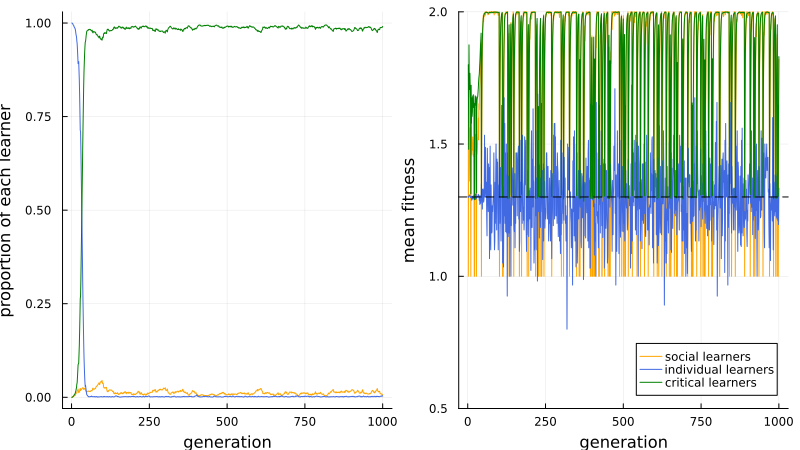

In [10]:
df = enquist_model()
@show mean(filter(!isnan, df.SLfitness))
@show mean(filter(!isnan, df.ILfitness))
@show mean(filter(!isnan, df.CLfitness))
plot_output(df)

## Analytical Appendix

### 1. Model 18a における社会的学習者の人口頻度 ($q_s$)

個人的学習者の適応度 ($w_i$) is given by:

$$
w_i = 1 + b p_i - c_i  \tag{18.1}
$$

- $b$: benefit of correct behaviour
- $p_i$: probability to get correct behaviour
- $c_i$: cost of individual learning ($c_i > 0$)

社会的学習者の適応度 ($w_s$) is given by:

$$
w_s = 1 + b q_{t-1} v  \tag{18.2}
$$

- $q_{t-1}$: 1世代前の正しい選択肢の比率
- $v$: 環境変化が起こらない確率 (つまり社会的学習が有効である確率) ($0 < v < 1$)

正しい選択肢の比率 ($q_t$) is given by:

$$
q_t = q_i p_i + q_s q_{t-1} v  \tag{18.3}
$$

- $q_i$: 個人的学習者の比率 ($q_i + q_s = 1$)
- $q_s$: 社会的学習者の比率 ($q_i + q_s = 1$)

$q_t$ の均衡 $q^*$ is given by:

$$
\begin{eqnarray}
q^* &=& (1 - q_s) p_i + q_s q^* v \\
q^* &=& \frac{(1 - q_s) p_i}{1 - q_s v} \tag{18.5}
\end{eqnarray}
$$

(18.2)(18.5)より、$q^*$ における社会的学習者の適応度 ($w_s$) is given by:

$$
w_s = 1 + \frac{(1 - q_s) b p_i v}{1 - q_s v} \tag{18.6}
$$

$q^*$において、$w_i = w_s$ とすると、(18.1)(18.6)より、社会的学習者の人口頻度の均衡 ($q_s^*$) is given by:

$$
q_s^* = \frac{c_i - b p_i (1 - v)}{c_i v}     \tag{18.7}
$$

In [11]:
# (18.7)
qₛ_equilibrium(; pᵢ::Float64, b::Float64, cᵢ::Float64, v::Float64)::Float64 =
    (cᵢ - b * pᵢ * (1 - v)) / (cᵢ * v);

Model 18a の実験1と実験3の結果の左側 (社会的学習者の人口頻度) が以下の様に再現されていることを確認できる。

In [12]:
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.9)
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.9);

qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.9) = 0.8333333333333334
qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.9) = 0.5555555555555557


但し、Model 18a の実験2の様に$v$が小さすぎたり大きすぎるときは、$w_i = w_s$ が成り立たないため、結果が正しく再現されない。

In [13]:
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.6)
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.5)
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.1)

@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 1.0);

qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.6) = 0.0
qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.5) = -0.4999999999999999
qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.1) = -12.499999999999998
qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 1.0) = 1.0


### 2. Model 18a における社会的学習者の人口頻度 ($q_s$)と適応度 ($w$) の関係

Model 18a の実験1と実験3の結果の右側 (社会的学習者と個人的学習者の適応度の比較) が以下の様に再現されていることを確認できる。

In [14]:
function qₛ_fitness(; pᵢ::Float64, b::Float64, cᵢ::Float64, v::Float64)::Nothing
    qₛ = collect(0:0.01:1)

    # Eq 18.1
    wᵢ = 1 + b * pᵢ - cᵢ

    # Eq 18.6
    wₛ = 1 .+ ((1 .- qₛ) .* b .* pᵢ .* v) ./ (1 .- qₛ .* v)

    # mean population fitness
    w = wᵢ .* (1 .- qₛ) .+ wₛ .* qₛ

    p = plot(
        xlab = "proportion of social learners ($(L"q_s"))",
        ylab = "fitness ($(L"w"))",
        ylim = [1, 1.5],
    )
    plot!(qₛ, wₛ, label = "social learner")
    hline!([wᵢ], label = "individual learner")
    # plot!(qₛ, w, label = "population")

    display(p)
end;

qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.9) = 0.8333333333333334


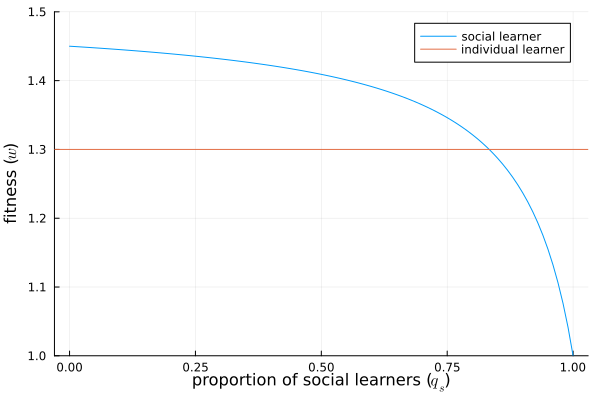

qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.9) = 0.5555555555555557


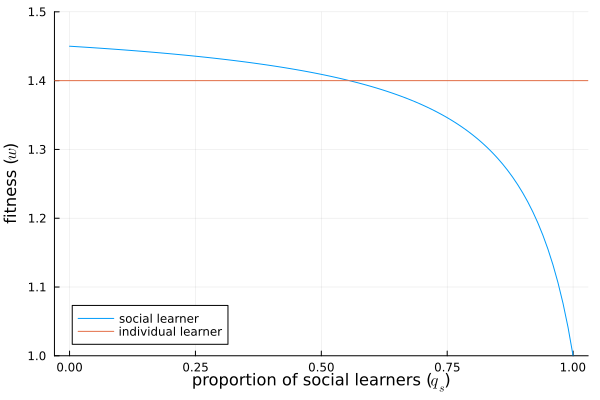

In [15]:
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.9)
qₛ_fitness(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.9)
@show qₛ_equilibrium(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.9)
qₛ_fitness(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.9)

- 社会的学習者と個人的学習者の適応度が一致する点 ($w_i = w_s$) の $q_s$ が、式18.7通りであることが確認できる。
- $q_s = 1.0$ でも交わってるけど、これは不安定固定点。
- $q_s = q^*$ は安定固定点。
    - $q_s < q^*$ の場合、個人的学習者が多く、社会的学習者は個人的学習者が見つけ出した正しいソリューションを真似することによって効率的に適応度を高めることができ、社会的学習者の人口頻度 ($q_s$) が増える。
    - $q_s > q^*$ の場合、個人的学習者が少なく、社会的学習者が真似する相手が少なく、環境変化に耐えられない。そのため、社会的学習者の人口頻度 ($q_s$) が減る。
    
### 3. Model 18b におけるクリティカル学習者の人口頻度 ($q_c$)と適応度 ($w$) の関係

クリティカル学習者の適応度 ($w_c$): 

$$
w_c = 1 + b q_{t-1} v + (b p_i - c_i)(1 - v) \tag{18.8}
$$

正しい行動が取られる確率 ($q_t$):

$$
q_t = q_i p_i + q_s q_{t-1} v + q_c (q_{t-1} v + (1 - q_{t-1} v) p_i) \tag{18.9}
$$

$q_t$ の均衡 ($q^*$): $q_t = q_{t-1} = q^*$ and $q_i = 1 - q_s - q_c$

$$
q^* = \frac{p_i (1 - q_s)}{1 - v (q_s + q_c (1 - p_i))} \tag{18.10}
$$

均衡 ($q^*$) において $q_s = 0$ となるので、式18.10は以下の様に整理できる。

$$
q^* = \frac{p_i}{1 - v  q_c (1 - p_i)} \tag{18.11}
$$

式18.8と式18.11より、クリティカル学習者の適応度 ($w_c$)は:

$$
w_c = 1 + \frac{b v p_i}{1 - v  q_c (1 - p_i)} + (b p_i - c_i)(1 - v) \tag{18.12}
$$


In [16]:
function q_c_fitness(; pᵢ::Float64, b::Float64, cᵢ::Float64, v::Float64)::Nothing
    q_c = collect(0:0.01:1)

    # Eq 18.1
    w_i = 1 + b * pᵢ - cᵢ

    # Eq 18.12
    w_c = 1 .+ (b * v * pᵢ) ./ (1 .- v .* q_c .* (1 - pᵢ)) .+ (b * pᵢ - cᵢ) * (1 - v)

    p = plot(
        xlab = "proportion of social learners ($(L"q_c"))",
        ylab = "fitness ($(L"w"))",
        ylim = [1, 2],
        title = "pᵢ=$(pᵢ), b=$(b), cᵢ=$(cᵢ), v=$(v)",
    )
    plot!(q_c, w_c, label = "critical learner")
    hline!([w_i], label = "individual learner")

    display(p)
end;

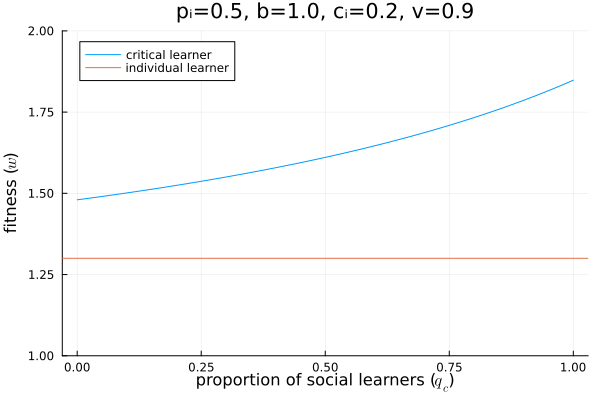

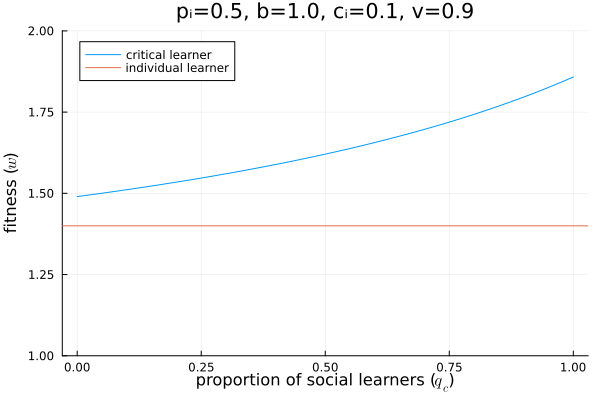

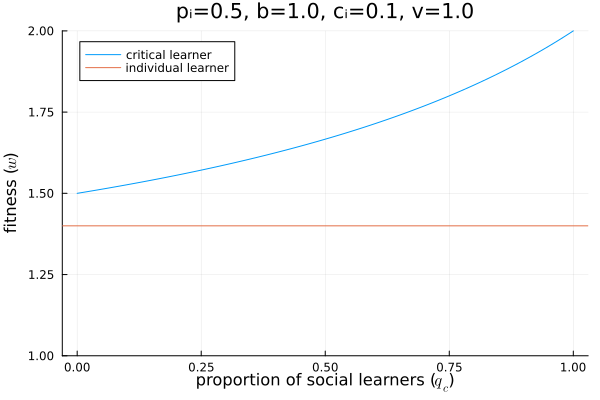

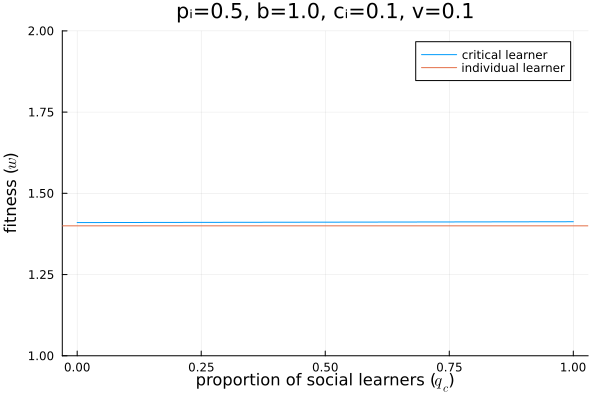

In [17]:
q_c_fitness(pᵢ = 0.5, b = 1.0, cᵢ = 0.2, v = 0.9)
q_c_fitness(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.9)
q_c_fitness(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 1.0)
q_c_fitness(pᵢ = 0.5, b = 1.0, cᵢ = 0.1, v = 0.1)